# Applied Data Analysis Project
**Team**: ToeStewBrr - Alexander Sternfeld, Marguerite Thery, Antoine Bonnet, Hugo Bordereaux

**Dataset**: CMU Movie Summary Corpus


In [28]:
import requests
import tarfile
import urllib
import os
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import re
import gzip
import ast
from nltk.tree import Tree
import xml.etree.ElementTree as ET
import itertools


## 1. Loading data

We first extract all files from the [MoviesSummaries dataset](http://www.cs.cmu.edu/~ark/personas/). 

In [29]:
if not os.path.exists('Data/MovieSummaries'):
    filename = 'http://www.cs.cmu.edu/~ark/personas/data/MovieSummaries.tar.gz'
    my_tar = tarfile.open(fileobj=urllib.request.urlopen(filename), mode="r:gz") 
    my_tar.extractall('./Data') # specify which folder to extract to
    my_tar.close()

`corenlp_plot_summaries.tar.gz [628 M, separate download]`: The plot summary of each movie, run through the Stanford CoreNLP pipeline (tagging, parsing, NER and coref). Each filename begins with the Wikipedia movie ID (which indexes into movie.metadata.tsv).

We now extract all coreNLP files, then uncompress them to the XML format. 

Note: Extraction of CoreNLP files takes 15 minutes, while conversion takes 30 seconds. 

In [30]:
# Extract all coreNLP files to Data/CoreNLP
if not os.path.exists('Data/CoreNLP'):
    coreNLPfilename = 'http://www.cs.cmu.edu/~ark/personas/data/corenlp_plot_summaries.tar'
    my_tar = tarfile.open(fileobj=urllib.request.urlopen(coreNLPfilename), mode="r|") 
    my_tar.extractall(path='./Data/CoreNLP') # specify which folder to extract to
    my_tar.close()

# Convert every file in directory Data/CoreNLP to xml format
raw_dir = 'Data/CoreNLP/corenlp_plot_summaries'
extracted_dir = 'Data/CoreNLP/corenlp_plot_summaries_xml'
if not os.path.exists(extracted_dir):
    os.mkdir(extracted_dir)
    for filename in os.listdir(raw_dir):
        f = os.path.join(raw_dir, filename) 
        if os.path.isfile(f):
            # Open and store file as xml 
            with gzip.open(f, 'rb') as f_in:
                gz_file = os.path.join(extracted_dir, filename)
                with open(gz_file[:-3], 'wb') as f_out:
                    f_out.write(f_in.read())



## 2. Pre-processing data

### 2.1. Plot summaries

`plot_summaries.txt [29 M]`: Plot summaries of 42,306 movies extracted from the November 2, 2012 dump of English-language Wikipedia.  Each line contains the Wikipedia movie ID (which indexes into movie.metadata.tsv) followed by the summary.

In [31]:
plot_path = 'Data/MovieSummaries/plot_summaries.txt'
plot_cols = ['Wikipedia ID', 'Summary']
plot_df = pd.read_csv(plot_path, sep='\t', header=None, names=plot_cols, index_col=0)
plot_df

,Summary
Wikipedia ID,
23890098,"Shlykov, a hard-working taxi driver and Lyosha..."
31186339,The nation of Panem consists of a wealthy Capi...
20663735,Poovalli Induchoodan is sentenced for six yea...
2231378,"The Lemon Drop Kid , a New York City swindler,..."
595909,Seventh-day Adventist Church pastor Michael Ch...
...,...
34808485,"The story is about Reema , a young Muslim scho..."
1096473,"In 1928 Hollywood, director Leo Andreyev look..."
35102018,American Luthier focuses on Randy Parsons’ tra...


In [32]:
# For Hugo: this method stems the words to their lexical root. 
# Implement Stemming using out of the box Porter algorithm
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()
plot_stemmed = [[stemmer.stem(word) for word in sentence.split(" ")] for sentence in plot_df.iloc[:5].Summary]
plot_stemmed = [" ".join(sentence) for sentence in plot_stemmed]


### 2.2. Movie metadata

`movie.metadata.tsv.gz [3.4 M]`: Metadata for 81,741 movies, extracted from the Noverber 4, 2012 dump of Freebase.  Tab-separated; columns:

1. Wikipedia movie ID
2. Freebase movie ID
3. Movie name
4. Movie release date
5. Movie box office revenue
6. Movie runtime
7. Movie languages (Freebase ID:name tuples)
8. Movie countries (Freebase ID:name tuples)
9. Movie genres (Freebase ID:name tuples)


In [35]:
strip_encoding = lambda x: np.nan if x == '{}' else \
    [w.replace(' Language', '').replace(' language', '') for w in re.findall(r'"(.*?)"', x)[1::2]]

movie_path = 'Data/MovieSummaries/movie.metadata.tsv'
movie_cols = ['Wikipedia ID', 'Freebase ID', 'Name', 'Release date', 
              'Box office revenue', 'Runtime', 'Languages', 'Countries', 'Genres']
movie_df = pd.read_csv(movie_path, sep='\t', header=None, names=movie_cols, index_col=0, dtype = {'Freebase ID': str})
movie_df['Languages'] = movie_df['Languages'].apply(strip_encoding)
movie_df['Countries'] = movie_df['Countries'].apply(strip_encoding)
movie_df['Genres'] = movie_df['Genres'].apply(strip_encoding)
movie_df

,Freebase ID,Name,Release date,Box office revenue,Runtime,Languages,Countries,Genres
Wikipedia ID,,,,,,,,
975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,..."
3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,[English],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]"
28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,[Norwegian],[Norway],"[Crime Fiction, Drama]"
9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,[English],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri..."
261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,[German],[Germany],[Drama]
...,...,...,...,...,...,...,...,...
35228177,/m/0j7hxnt,Mermaids: The Body Found,2011-03-19,NaN,120.0,[English],[United States of America],[Drama]
34980460,/m/0g4pl34,Knuckle,2011-01-21,NaN,96.0,[English],"[Ireland, United Kingdom]","[Biographical film, Drama, Documentary]"
9971909,/m/02pygw1,Another Nice Mess,1972-09-22,NaN,66.0,[English],[United States of America],"[Satire, Comedy]"


### 2.3. Character metadata

`character.metadata.tsv.gz [14 M]`: Metadata for 450,669 characters aligned to the movies above, extracted from the November 4, 2012 dump of Freebase.  Tab-separated; columns:

1. Wikipedia movie ID
2. Freebase movie ID
3. Movie release date
4. Character name
5. Actor date of birth
6. Actor gender
7. Actor height (in meters)
8. Actor ethnicity (Freebase ID)
9. Actor name
10. Actor age at movie release
11. Freebase character/actor map ID
12. Freebase character ID
13. Freebase actor ID


In [36]:
char_path = 'Data/MovieSummaries/character.metadata.tsv'
char_cols = ['Wikipedia ID', 'Freebase ID', 'Release date', 'Character name', 'Date of birth', 
             'Gender', 'Height', 'Ethnicity', 'Actor name', 'Actor age at release', 
             'Freebase character/map ID', 'Freebase character ID', 'Freebase actor ID']
char_df = pd.read_csv(char_path, sep='\t', header=None, names=char_cols, index_col=0)
char_df

,Freebase ID,Release date,Character name,Date of birth,Gender,Height,Ethnicity,Actor name,Actor age at release,Freebase character/map ID,Freebase character ID,Freebase actor ID
Wikipedia ID,,,,,,,,,,,,
975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg
...,...,...,...,...,...,...,...,...,...,...,...,...
913762,/m/03pcrp,1992-05-21,Elensh,1970-05,F,NaN,NaN,Dorothy Elias-Fahn,NaN,/m/0kr406c,/m/0kr406h,/m/0b_vcv
913762,/m/03pcrp,1992-05-21,Hibiki,1965-04-12,M,NaN,NaN,Jonathan Fahn,27.0,/m/0kr405_,/m/0kr4090,/m/0bx7_j
28308153,/m/0cp05t9,1957,NaN,1941-11-18,M,1.730,/m/02w7gg,David Hemmings,15.0,/m/0g8ngmc,NaN,/m/022g44


### 2.4. Name clusters

`name.clusters.txt`: 970 unique character names used in at least two different movies, along with 2,666 instances of those types.  The ID field indexes into the Freebase character/actor map ID in character.metadata.tsv.

In [37]:
path = 'Data/MovieSummaries/'
names_path = path+'name.clusters.txt'
names_cols = ['Character name', 'Cluster']
names_df = pd.read_csv(names_path, sep='\t', header=None, names=names_cols, dtype = {'Freebase ID': str})
names_df = names_df.groupby('Character name').aggregate(list)
names_df

,Cluster
Character name,
'Baby' Louise,"[/m/0c0lv89, /m/0h2cmv_]"
ACP Jai Dixit,"[/m/0jx7ny, /m/0220_c2]"
Abigail Chase,"[/m/02vcd9h, /m/0k14v6]"
Abraham Lincoln,"[/m/0k059l1, /m/0k89pf, /m/02tbdlx]"
Abraham Van Helsing,"[/m/0jwq7y, /m/02vc_c7, /m/0jxjq1, /m/0k4llv, ..."
...,...
Yosemite Sam,"[/m/0hynrhr, /m/0hyn6wh, /m/0hynsvw, /m/0hynzf..."
Young Jack,"[/m/03jq87t, /m/03jppd0]"
Young Jake,"[/m/0hndzk9, /m/0bwsx65]"


### 2.5. TV Tropes Clusters

`tvtropes.clusters.txt`: 72 character types drawn from tvtropes.com, along with 501 instances of those types.  The ID field indexes into the Freebase character/actor map ID in character.metadata.tsv.

In [38]:
cluster_path = path+'tvtropes.clusters.txt'
cluster_cols = ['Cluster', 'Character data']
cluster_df = pd.read_csv(cluster_path, sep='\t', header=None, names=cluster_cols, dtype = {'Freebase ID': str})
cluster_df['Character data'] = cluster_df['Character data'].apply(lambda x: ast.literal_eval(x))
cluster_df['Character name'] = cluster_df['Character data'].apply(lambda x: x['char'])
cluster_df['Movie'] = cluster_df['Character data'].apply(lambda x: x['movie'])
cluster_df['Freebase character/map ID'] = cluster_df['Character data'].apply(lambda x: x['id'])
cluster_df['Actor'] = cluster_df['Character data'].apply(lambda x: x['actor'])
cluster_df.drop('Character data', axis=1, inplace=True)
cluster_df


,Cluster,Character name,Movie,Freebase character/map ID,Actor
0,absent_minded_professor,Professor Philip Brainard,Flubber,/m/0jy9q0,Robin Williams
1,absent_minded_professor,Professor Keenbean,Richie Rich,/m/02vchl3,Michael McShane
2,absent_minded_professor,Dr. Reinhardt Lane,The Shadow,/m/0k6fkc,Ian McKellen
3,absent_minded_professor,Dr. Harold Medford,Them!,/m/0k6_br,Edmund Gwenn
4,absent_minded_professor,Daniel Jackson,Stargate,/m/0k3rhh,James Spader
...,...,...,...,...,...
496,young_gun,Morgan Earp,Tombstone,/m/0k776f,Bill Paxton
497,young_gun,Colorado Ryan,Rio Bravo,/m/0k2kqg,Ricky Nelson
498,young_gun,Tom Sawyer,The League of Extraordinary Gentlemen,/m/0k5nsh,Shane West
499,young_gun,William H. 'Billy the Kid' Bonney,Young Guns II,/m/03lrjk0,Emilio Estevez


We now join the TV tropes clusters with movie.metadata so we are able to access movie genre and filter on romance. 

In [39]:
# TODO: Fix this
cluster_char = cluster_df.merge(char_df, on='Freebase character/map ID')
cluster_char_movie = cluster_char.merge(movie_df, on='Freebase ID')
romance_cluster = cluster_char_movie[cluster_char_movie['Genres'].apply(lambda x: 'Roman' in x)]
romance_cluster.groupby(romance_cluster['Cluster']).size().sort_values(ascending=False)
romance_cluster

,Cluster,Character name_x,Movie,Freebase character/map ID,Actor,Freebase ID,Release date_x,Character name_y,Date of birth,Gender,...,Actor age at release,Freebase character ID,Freebase actor ID,Name,Release date_y,Box office revenue,Runtime,Languages,Countries,Genres


## 3. Exploratory Data Analysis


### 3.0. Preprocessing, including outlier analysis

#### Identifying missing values

In [40]:
# Missing values
for column in movie_cols[3:]:
    number_missing = movie_df[column].isna().sum()
    print('Missing values of ', column, ': ', number_missing, ' (',round(100*number_missing/movie_df.shape[0],2), '%)')


Missing values of  Release date :  6902  ( 8.44 %)
Missing values of  Box office revenue :  73340  ( 89.72 %)
Missing values of  Runtime :  20450  ( 25.02 %)
Missing values of  Languages :  13866  ( 16.96 %)
Missing values of  Countries :  8154  ( 9.98 %)
Missing values of  Genres :  2294  ( 2.81 %)


#### Outliers
- We note that there is one movie with a release date in the year 1010, we manually correct this to the date 2010
- There are many movies with very short runtimes (under 5 minutes). We manually verified a sample of these movies, and have found that the runtimes are correct.
- There are over a hundred movies with runtimes over 5 hours. We have found that most of these data points correspond to series, where the runtime is the sum of the episode lengths.
- One movie has a runtime of over a million minutes ('Zero tolerance'). This lengths is manually corrected to 88 minutes.

In [41]:
# Isolate the year from the release date
getYear = lambda x: x[slice(0,4)] if type(x) == str else x
movie_df['Release date'] = movie_df['Release date'].apply(getYear)

# Identify suspicious movie with release date 1010, manually correct
outlier_release_date = movie_df[movie_df['Release date'].apply(lambda x: int(x.split('-')[0]) < 1850 if type(x)==str else False)]
movie_df.at[29666067, 'Release date'] = 2010

# Identify suspicious movies with long runtimes
movie_df[movie_df['Runtime'] > 300]
movie_df.at[10815585, 'Runtime'] = 88

### 3.1. Analysing romantic genres

One notices that there are several types of romantic movies: romantic comedy, romance film, romantic drama. 

In [42]:
romance_genres = ['Romantic comedy', 'Romance Film', 'Romantic drama', 'Romantic fantasy', 'Romantic thriller']
is_romantic = lambda i: lambda x: any(y in romance_genres[i] for y in x) if type(x) == list else False
is_not_romantic = lambda i: lambda x: not any(y in romance_genres[i] for y in x) if type(x) == list else False
romance_movies = movie_df[movie_df['Genres'].apply(is_romantic(slice(0, 5)))]
non_romance_movies = movie_df[movie_df['Genres'].apply(is_not_romantic(slice(0, 5)))]

In [43]:
#Organize by category
romantic_comedy = romance_movies.loc[movie_df['Genres'].apply(is_romantic(0))]
romantic_film = romance_movies.loc[movie_df['Genres'].apply(is_romantic(1))]
romantic_drama = romance_movies.loc[movie_df['Genres'].apply(is_romantic(2))]
romantic_fantasy = romance_movies.loc[movie_df['Genres'].apply(is_romantic(3))]
romantic_thriller = romance_movies.loc[movie_df['Genres'].apply(is_romantic(4))]
print('Roman' , romance_movies.shape[0])
print('Romantic comedies: ', romantic_comedy.shape[0], '\nRomantic films: ', romantic_film.shape[0], '\nRomantic drama: ', romantic_drama.shape[0], '\nRomantic fantasy: ', romantic_fantasy.shape[0], '\nRomantic thriller: ', romantic_thriller.shape[0])
print('Total number of films: ', movie_df.shape[0])

Roman 11131
Romantic comedies:  2680 
Romantic films:  10234 
Romantic drama:  3372 
Romantic fantasy:  72 
Romantic thriller:  1
Total number of films:  81741


### 3.2. Romantic movies runtime

In [44]:
##Should correct outliers
#combined_runtime = pd.DataFrame({'Romantic comedy': romantic_comedy['Runtime'], 'Romance Film': romantic_film['Runtime'], 'Romantic drama': romantic_drama['Runtime'], 'Romantic fantasy': romantic_fantasy['Runtime']})
#sns.boxplot(combined_runtime)


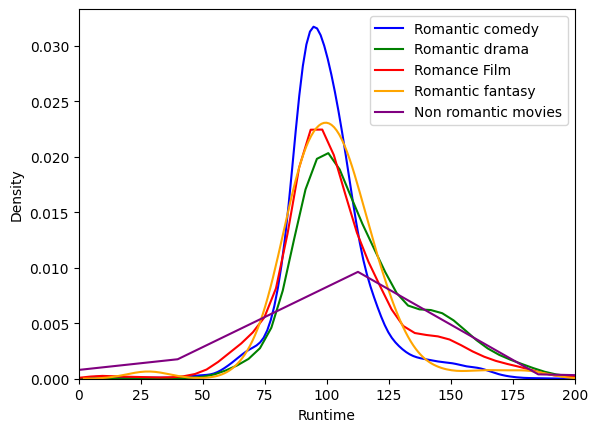

In [45]:
ax = sns.kdeplot(romantic_comedy['Runtime'], color='blue')
ax = sns.kdeplot(romantic_drama['Runtime'], color='green')
ax = sns.kdeplot(romantic_film['Runtime'], color='red')
ax = sns.kdeplot(romantic_fantasy['Runtime'], color='orange')
ax = sns.kdeplot(non_romance_movies['Runtime'], color = 'purple')
ax.set_xlim(0, 200)
ax.legend(['Romantic comedy', 'Romantic drama', 'Romance Film', 'Romantic fantasy', 'Non romantic movies'])


### 3.3. Romantic movies box office revenue

In [46]:
#Does not give a good view
#combined_box_office = pd.DataFrame({'Romantic comedy': romantic_comedy['Box office revenue'], 'Romance Film': romantic_film['Box office revenue'], 'Romantic drama': romantic_drama['Box office revenue'], 'Romantic fantasy': romantic_fantasy['Box office revenue']})
#sns.boxplot(combined_box_office)

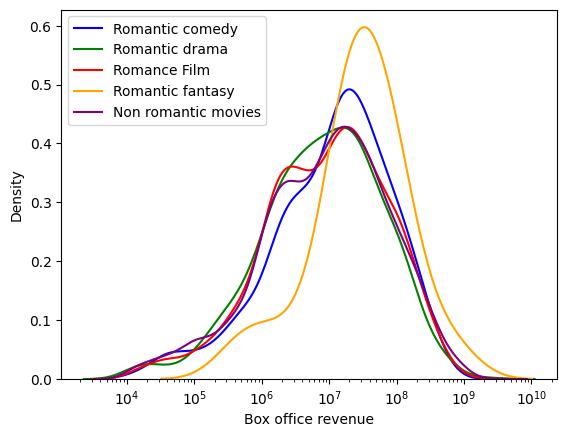

In [47]:
ax = sns.kdeplot(romantic_comedy['Box office revenue'], log_scale=True, color='blue')
ax = sns.kdeplot(romantic_drama['Box office revenue'], log_scale=True, color='green')
ax = sns.kdeplot(romantic_film['Box office revenue'], log_scale=True, color='red')
ax = sns.kdeplot(romantic_fantasy['Box office revenue'], log_scale=True, color='orange')
ax = sns.kdeplot(non_romance_movies['Box office revenue'], log_scale=True, color='purple')
ax.legend(['Romantic comedy', 'Romantic drama', 'Romance Film', 'Romantic fantasy', 'Non romantic movies'])


### 3.4. Romantic movies countries

In [48]:
get_countries = lambda x: len(x) if type(x) == list else np.nan
romantic_comedy['number_countries'] = romantic_comedy['Countries'].apply(get_countries)
romantic_fantasy['number_countries'] = romantic_fantasy['Countries'].apply(get_countries)
romantic_film['number_countries'] = romantic_film['Countries'].apply(get_countries)
romantic_drama['number_countries'] = romantic_drama['Countries'].apply(get_countries)

combined_numb_countries = pd.DataFrame({
    'Romantic comedy': romantic_comedy['number_countries'], 
    'Romance Film': romantic_film['number_countries'], 
    'Romantic drama': romantic_drama['number_countries'], 
    'Romantic fantasy': romantic_fantasy['number_countries']})

print('Percentage romantic comedy movie countries > 1: ', round(romantic_comedy[romantic_comedy['number_countries']> 1].shape[0]/romantic_comedy.shape[0], 2), '%')
print('Other countries can be added in code...')

Percentage romantic comedy movie countries > 1:  0.14 %
Other countries can be added in code...


/var/folders/rh/x2hr79s123s3bct3lj6kl28w0000gn/T/ipykernel_65600/2615585845.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  romantic_comedy['number_countries'] = romantic_comedy['Countries'].apply(get_countries)
/var/folders/rh/x2hr79s123s3bct3lj6kl28w0000gn/T/ipykernel_65600/2615585845.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  romantic_fantasy['number_countries'] = romantic_fantasy['Countries'].apply(get_countries)
/var/folders/rh/x2hr79s123s3bct3lj6kl28w0000gn/T/ipykernel_65600/2615585845.py

### 3.5. Movie languages

In [49]:
#Get languages whole movie set
movies_language = movie_df[movie_df['Languages'].notnull()]
languages=movies_language['Languages'].sum()
values, counts = np.unique(languages, return_counts=True)
print('5 most common languages in movies are: ')
print(values[counts.argsort()[-5:][::-1]])

#Get languages romantic movies overall
romance_movies_lang = romance_movies[romance_movies['Languages'].notnull()]
languages_romance = romance_movies_lang.Languages.sum()
values, counts = np.unique(languages_romance, return_counts=True)
print('\n5 most common languages in romantic movies: ')
print(values[counts.argsort()[-5:][::-1]])


rom_com_known = romantic_comedy[romantic_comedy['Languages'].notnull()]
languages_romcom = rom_com_known.Languages.sum()
values, counts = np.unique(languages_romcom, return_counts=True)
print('\n5 most common languages in romantic comedies: ')
print(values[counts.argsort()[-5:][::-1]])

5 most common languages in movies are: 
['English' 'Hindi' 'Spanish' 'French' 'Silent film']

5 most common languages in romantic movies: 
['English' 'Hindi' 'French' 'Tamil' 'Spanish']

5 most common languages in romantic comedies: 
['English' 'French' 'Hindi' 'Spanish' 'Italian']


### 3.6. Evolution over time

#### 3.6.1 Box office revenue over time

TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

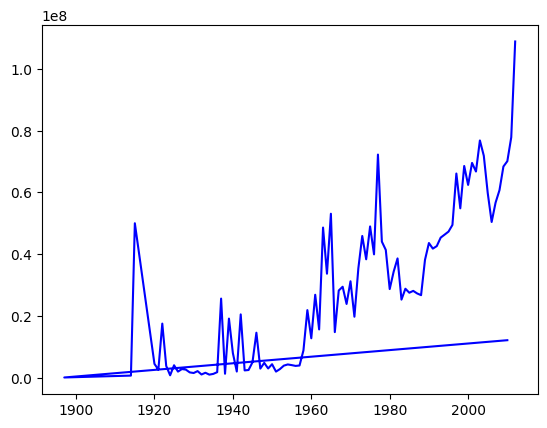

In [50]:
##year_box_office = non_romance[['Release date', 'Box office revenue']].dropna()
year_box_office = movie_df[['Release date', 'Box office revenue']].dropna()
year_box_office_romance = romance_movies[['Release date', 'Box office revenue']].dropna()
yearly_revenue_total = year_box_office.groupby('Release date').mean()
yearly_revenue_romance = year_box_office_romance.groupby('Release date').mean()
plt.plot(yearly_revenue_total.index, yearly_revenue_total['Box office revenue'],'b-',  label = 'Average box office revenue')
plt.fill_between(yearly_revenue_total.index, yearly_revenue_total['Box office revenue'] - yearly_revenue_total['Box office revenue'].std(), yearly_revenue_total['Box office revenue'] + yearly_revenue_total['Box office revenue'].std(), color='blue', alpha=0.2)
plt.plot(yearly_revenue_romance.index, yearly_revenue_romance['Box office revenue'],'r-',  label = 'Average box office revenue romantic films')
plt.fill_between(yearly_revenue_romance.index, yearly_revenue_romance['Box office revenue'] - yearly_revenue_romance['Box office revenue'].std(), yearly_revenue_romance['Box office revenue'] + yearly_revenue_romance['Box office revenue'].std(), color='red', alpha=0.2)
plt.legend()
ax = plt.gca()
plt.ylabel('Box office revenue')
plt.xlabel('Year')
ax.xaxis.set_major_locator(plt.MaxNLocator(10))
plt.show()

### 3.6.2. Evolution of runtime

TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

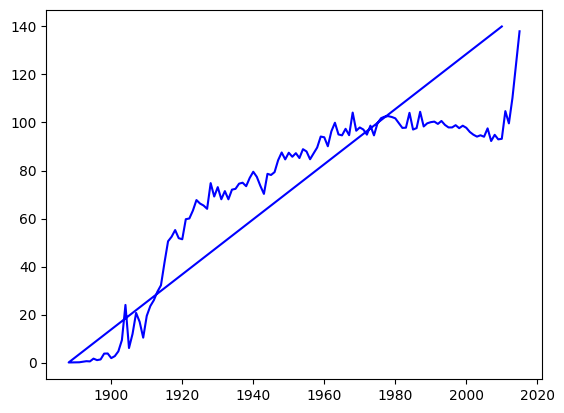

In [51]:
yearly_runtime_non_romance = non_romance_movies[['Release date', 'Runtime']].dropna().groupby('Release date').mean()
yearly_runtime_romance = romance_movies[['Release date', 'Runtime']].dropna().groupby('Release date').mean()
plt.plot(yearly_runtime_non_romance.index, yearly_runtime_non_romance['Runtime'], 'b-',  label = 'Average runtime non romantic movies')
plt.fill_between(yearly_runtime_non_romance.index, yearly_runtime_non_romance['Runtime'] - yearly_runtime_non_romance['Runtime'].std(), yearly_runtime_non_romance['Runtime'] + yearly_runtime_non_romance['Runtime'].std(), color='blue', alpha=0.2)
plt.plot(yearly_runtime_romance.index, yearly_runtime_romance['Runtime'], 'r-',  label = 'Average runtime romantic movies')
plt.fill_between(yearly_runtime_romance.index, yearly_runtime_romance['Runtime'] - yearly_runtime_romance['Runtime'].std(), yearly_runtime_romance['Runtime'] + yearly_runtime_romance['Runtime'].std(), color='red', alpha=0.2)
plt.legend()
ax = plt.gca()
plt.ylabel('Runtime')
plt.xlabel('Year')
ax.xaxis.set_major_locator(plt.MaxNLocator(10))
plt.show()

### 3.7. CoreNLP Plot summaries

#### 3.7.1 Extracting characters

For any character, we want to extract related information (from name clusters, character metadata) as well as actions, characteristics and relations (from CoreNLP). We first extract information from the pre-processed dataframes. 

We will use Harry Potter's character as an example

In [52]:
char_name = 'Harry Potter'
movie_ids = list(char_df[char_df['Character name'] == 'Harry Potter'].index)
char_ids = names_df.loc[char_name].values[0]
trope = cluster_df.loc[cluster_df['Character name'] == char_name]
# if trop is empty, set trope to None
if trope.empty:
    trope = None

print('Movies with character', char_name, ':')
print('\tMovie IDs:', movie_ids)
print('\tCharacter IDs:', char_ids)
print('\tTrope:', trope)

movie_id = movie_ids[3] 
print('Selecting movie ID as example:', movie_id)

Movies with character Harry Potter :
	Movie IDs: [858575, 667372, 670407, 31941988, 9834441, 667368, 667371, 667361, 667361]
	Character IDs: ['/m/0jz6jt', '/m/02tbbh6', '/m/0jz6mq', '/m/0jz6hs', '/m/02tbf6n', '/m/0jz6b0', '/m/0jz6dz', '/m/09lybcb']
	Trope: None
Selecting movie ID as example: 31941988


We now extract information from the CoreNLP plot summary analysis. Each xml file has a tree structure, which we can parse as shown below. 

In [57]:
# To get the tree from xml CoreNLP output
def get_tree(movie_id):
    xml_filename = os.path.join(extracted_dir, '{}.xml'.format(movie_id))
    tree = ET.parse(xml_filename)
    return tree



We can extract all parsed sentences from the xml file, each of which we can view as a tree structure. 

In [58]:
# Given an xml file, we return all of its CoreNLP parsed sentences 
def get_parsed_sentences(tree):
    sentences = []
    root = tree.getroot()
    for child in tree.iter():
        if child.tag == "parse":
            sentences.append(child.text)
    return sentences

# To print parsed sentences as a pretty tree. 
def print_tree(parsed_string):
    tree = Tree.fromstring(parsed_string)
    tree.pretty_print()


In [59]:
tree = get_tree(movie_id)
parsed_str = get_parsed_sentences(tree)[5]
print_tree(parsed_str)

                                                ROOT                                                 
                                                 |                                                    
                                                 S                                                   
                _________________________________|_________________________________________________   
               |             |    |                               VP                               | 
               |             |    |        _______________________|____                            |  
               |             |    |       |                           SBAR                         | 
               |             |    |       |                            |                           |  
               |             |    |       |                            S                           | 
               |             |    |       |            ________________|______

We also want to extract all character names from the xml file. Note that we aggregate consecutive words tagged as NNP (noun, proper, singular) as the same character name (this assumes that plot summaries never contain two distinct names side by side without delimiting punctuation). This is a reasonable assumption since list of names are almost always separated by commas. 

In [79]:
def get_characters(tree):
    characters = []
    current_word = None
    was_person = False
    character = ''
    for child in tree.iter():
        if child.tag == 'word':
            current_word = child.text
        if child.tag == 'NER' and child.text == 'PERSON':
            if was_person:# Continue the character
                character += ' ' + current_word
            else: # Start the character
                character = current_word
                was_person = True
        if was_person and child.tag == 'NER' and child.text != 'PERSON': # End the character
            characters.append(character)
            character = ''
            was_person = False
    return characters

In [80]:
characters = get_characters(tree)
characters[:15]

['Voldemort',
 'Albus Dumbledore',
 'Severus Snape',
 'Dobby',
 'Harry Potter',
 'Ron',
 'Hermione',
 'Griphook',
 'Harry',
 'Ollivander',
 'Ollivander',
 'Draco Malfoy',
 'Malfoy',
 'Harry',
 'Harry']

In [81]:
# DISCARD THIS METHOD?

# Given a character in a movie, find all sentences mentioning the character
def sentences_with_character(xml_filename, char_name):
    char_sentences = []
    if os.path.isfile(xml_filename):
        sentences = get_parsed_sentences(xml_filename)
        char_sentences = [sentence for sentence in sentences if char_name in sentence]
    return char_sentences

Notice that some characters are sometimes mentioned by their full name, and sometimes by a partial name (e.g. Harry Potter is most often mentioned as simply Harry). To get a more precise idea of how many times each character is mentioned, we wish to denote each character by their full name, i.e. the longest version of their name that appears in the plot summary. 

To optimize full name lookup, for each plot summary we construct a dictionary which stores as key every partial name mentioned, and as corresponding values the full name of each character.  

In [82]:
def get_full_name(string, characters):
    ''' 
    Find the longest name of a given character in a list of character names. 
    Input: 
        string: character name (partial or full)
        characters: list of character names
    Output: 
        full_name: longest name of character found in characters
    '''
    names = string.split(' ')
    max_length = 0
    for character in characters:
        char_names = character.split(' ')
        if set(names) <= set(char_names): 
            num_names = len(char_names)
            if num_names > max_length:
                max_length = num_names
                full_name = character
    return full_name

# Helper function: given a list of characters, make a dictionary with all maps (short name : full name)
def full_name_dict(characters): 
    full_names = {}
    for character in characters:
        full_names[character] = get_full_name(character, characters)
    return full_names


In [83]:
# Toy example
characters_example = ['Harry Potter', 'Harry', 'Lord Voldemort', 'Harry James Potter', 'Dumbledore', 'Albus Dumbledore']
print('Full name:', get_full_name('Harry Potter', characters_example))
print('All full name pairs:', full_name_dict(characters_example))

Full name: Harry James Potter
All full name pairs: {'Harry Potter': 'Harry James Potter', 'Harry': 'Harry James Potter', 'Lord Voldemort': 'Lord Voldemort', 'Harry James Potter': 'Harry James Potter', 'Dumbledore': 'Albus Dumbledore', 'Albus Dumbledore': 'Albus Dumbledore'}



We can now construct a dictionary with keys being the characters' full name and values being the number of times any version of their name is mentioned. 

In [84]:
# Given a list of characters names, create a dictionary of characters with 
# keys being their full name and values being the number of times they appear in the list

def aggregate_characters(characters):
    ''' 
    Input: list of characters
    Output: dictionary of (full name : number of times name is mentioned in list)
    Example: ['Harry Potter', 'Voldemort', 'Harry'] -> {'Harry Potter': 2, 'Voldemort': 1}
    '''
    character_dict = dict()
    for character in characters:
        full_character = get_full_name(character, characters)
        if full_character in character_dict:
            character_dict[full_character] += 1
        else:
            character_dict[full_character] = 1
    return character_dict


In [86]:
aggregate_characters(characters)

{'Voldemort': 21,
 'Albus Dumbledore': 5,
 'Severus Snape': 11,
 'Dobby': 1,
 'Harry Potter': 26,
 'Ron': 6,
 'Hermione Weasley': 6,
 'Griphook': 3,
 'Ollivander': 2,
 'Draco Malfoy': 3,
 'Helga Hufflepuff': 1,
 'Rowena Ravenclaw': 1,
 'Hogsmeade': 1,
 'Aberforth Dumbledore': 1,
 'Ariana': 1,
 'Neville Longbottom': 3,
 'Minerva McGonagall': 1,
 'Luna Lovegood': 1,
 'Helena Ravenclaw': 1,
 'Gregory Goyle': 1,
 'Blaise Zabini': 1,
 'Nagini': 3,
 'Fred': 1,
 'Lily': 2,
 'James': 1,
 'Molly Weasley': 1,
 'Ginny Potter': 1}

We can now extract the most mentioned characters in any plot summary. 

In [87]:
# Given a parse tree, extract the most mentioned characters in decreasing order
def most_mentioned(tree):
    '''
    Input: 
        tree: parse tree of the xml file
        N: the number of characters to return
    Output:
        A dictionary of the N characters most mentioned in the movie
    '''
    characters = get_characters(tree)
    character_dict = aggregate_characters(characters)
    sorted_characters = sorted(character_dict.items(), key=lambda x: x[1], reverse=True)
    return sorted_characters

In [88]:
most_mentioned(tree)[:10]

[('Harry Potter', 26),
 ('Voldemort', 21),
 ('Severus Snape', 11),
 ('Ron', 6),
 ('Hermione Weasley', 6),
 ('Albus Dumbledore', 5),
 ('Griphook', 3),
 ('Draco Malfoy', 3),
 ('Neville Longbottom', 3),
 ('Nagini', 3)]

 #### 3.6.2. Extracting relationships

 We cannot extract character interactions directly from the CoreNLP output (or can we?). Instead, we use the number of common mentions of two characters in the same sentence as a proxy for the number of interactions. We first define a method that gets the full name of all characters mentioned in each sentence. 

In [90]:
# Given a list of characters and a string sentence, find the sequence of characters appearing in the sentence
def characters_in_sentence(characters, sentence):
    '''
    Input: 
        characters: list of characters
        sentence: string
    Output: 
        characters_mentioned: list of characters that appear in the sentence
        characters: list of remaining characters
    Example: characters_in_sentence(['Harry Potter', 'Voldemort', 'Dumbledore'], 'Harry Potter fights Voldemort bravely.')
    Output: ['Harry Potter', 'Voldemort'], ['Dumbledore']
    '''
    characters_mentioned = []
    if (len(characters) == 0):
            return characters_mentioned, characters
    character = characters.pop(0)
    while character in sentence:
        sentence = sentence.split(character, 1)[1]
        characters_mentioned.append(character)
        if (len(characters) == 0):
            break
        character = characters.pop(0)
    return characters_mentioned, characters



In [91]:
plot_summary = plot_df.loc[movie_id].values[0]
sentences = re.split(r'(?<=[.!?])\s+', plot_summary)
print('First sentence:', sentences[0])
print('Characters:', characters[:10])
characters_mentioned, characters_rem = characters_in_sentence(characters[:10], sentences[0])
print('Characters mentioned:', characters_mentioned)
print('Remaining characters:', characters_rem)

First sentence: {{further2}} {{See also}}  As Lord Voldemort retrieves the Elder Wand from Albus Dumbledore's grave, Severus Snape has become Hogwarts headmaster.
Characters: ['Voldemort', 'Albus Dumbledore', 'Severus Snape', 'Dobby', 'Harry Potter', 'Ron', 'Hermione', 'Griphook', 'Harry', 'Ollivander']
Characters mentioned: ['Voldemort', 'Albus Dumbledore', 'Severus Snape']
Remaining characters: ['Harry Potter', 'Ron', 'Hermione', 'Griphook', 'Harry', 'Ollivander']


We define a method that takes in a movie ID, and outputs the number of common mentions (i.e. interactions) for each pair of characters. 

In [ ]:

def character_pairs(movie_id):
    ''' 
    Find all pairs of characters that appear in the same sentence in a movie plot summary. 
    Input: 
        movie_id: integer Movie ID
    Output:
        A list of all character pairs in the movie in decreasing order of frequency
    '''
    char_pairs = dict()

    # Parse xml file and get all characters from plot summary
    xml_filename = os.path.join(extracted_dir, '{}.xml'.format(movie_id))
    tree = ET.parse(xml_filename)
    characters = get_characters(tree)
    full_name_map = full_name_dict(characters) # all maps (partial name : full name)

    # Split plot summary into sentences
    plot_summary = plot_df.loc[movie_id].values[0]
    sentences = re.split(r'(?<=[.!?])\s+', plot_summary)

    # For each sentence, find the characters mentioned and their full names, then add count for each pair between them
    for sentence in sentences:
        # Only consider sentences with at least 2 mentioned characters
        characters_mentioned, characters = characters_in_sentence(characters, sentence)
        if len(characters_mentioned) >= 2: 
            
            # Get full names of each character mentioned, remove doubles
            full_mentioned = set([full_name_map[c] for c in characters_mentioned])

            # Add count for each pair of characters
            pairs = list(itertools.combinations(sorted(full_mentioned), 2))
            for pair in pairs:
                if pair in char_pairs:
                    char_pairs[pair] += 1
                else:
                    char_pairs[pair] = 1
    
    # Sort character pairs by number of times they appear together
    sorted_pairs = sorted(char_pairs.items(), key=lambda x: x[1], reverse=True)
    return sorted_pairs

In [ ]:
character_pairs(movie_id)[:10]

In [ ]:
# Given a movie ID, find the character pairs with the highest number of interactions (both mentioned in a single sentence).
def most_interactions(movie_ID, num_pairs):
    # Get all characters in the movie
    xml_filename = os.path.join(extracted_dir, '{}.xml'.format(movie_ID))
    tree = ET.parse(xml_filename)
    characters = get_characters(tree)

    # Find the plot summary sentences with at least two characters 
    plot_summary = plot_df.loc[movie_id].values[0]
    sentences = re.split(r'(?<=[.!?])\s+', plot_summary)
    

    # Find the character pairs with the most interactions
    character_pairs = dict()
    for sentence in sentences:
        characters = get_characters(sentence)
        character_pairs = aggregate_characters(characters)



We would like to identify the two main characters in a plot summary. 

In [ ]:
#TODO: only consider romantic movies
#TODO: Aggregate consecutive entity names inton one
extracted_dir = 'Data/CoreNLP/corenlp_plot_summaries_xml'

def make_pairs (extracted_dir): 
  pairs = []
  for filename in os.listdir(extracted_dir):
      f = os.path.join(extracted_dir, filename) 
      if os.path.isfile(f):
          # Create characters list for each file 
          characters = []
          tree = ET.parse(f)
          root = tree.getroot()
          for child in tree.iter():
              if child.tag == "word":
                current_word = child.text
              if child.tag == "NER": 
                if child.text == "PERSON":
                  characters.append(current_word)
          # Select the two characters which appear most often in the file
          values, counts = np.unique(characters, return_counts=True)
          two_most_frequent_characters = values[counts.argsort()[-2:][::-1]]
          # If there exists two characters, create a pair 
          if len(two_most_frequent_characters) > 1:
            pairs.append([f.replace('Data/CoreNLP/corenlp_plot_summaries_xml/', '').replace('.xml', ''), two_most_frequent_characters[0], two_most_frequent_characters[1]])
  return pairs

# Convert into an array and as a dataframe
pairs = make_pairs(extracted_dir)
pairs = np.asarray(pairs).reshape(-1, 3)  
pairs_df = pd.DataFrame(pairs, columns=['Wikipedia ID', 'char1', 'char2']) 
pairs_df                                     

In [ ]:
# Merge pairs dataset with characters 
char_df['Wikipedia ID'] = char_df['Wikipedia ID'].astype(str)
pairs_df['Wikipedia ID'] = pairs_df['Wikipedia ID'].astype(str)
pairs_char = pairs_df.merge(char_df, on="Wikipedia ID")

# Filter out the nan values
pairs_char = pairs_char[~pairs_char['Character name'].isna()]

# Create columns which indicates if char1 and char2 are in character name 
pairs_char['char1_is_in_name'] = pairs_char.apply(lambda x: 1 if x['char1'] in x['Character name'] else 0, axis=1)
pairs_char['char2_is_in_name'] = pairs_char.apply(lambda x: 1 if x['char2'] in x['Character name'] else 0, axis=1)
pairs_char[pairs_char['char1_is_in_name'] == 1 & pairs_char['char2_is_in_name'] == 1]

### 3.7. CoreNLP Analysis

To use the powerful CoreNLP model, first [download it](https://stanfordnlp.github.io/CoreNLP/download.html), then cd into the downloaded `stanford-corenlp` directory. If you have Java, you can run the following command to open a CoreNLP shell: 


`java -mx4g -cp "*" edu.stanford.nlp.pipeline.StanfordCoreNLPServer` 
 
Now that the shell is running, we can use their models to annotate some sentences. 

In [ ]:
from pycorenlp import StanfordCoreNLP
nlp = StanfordCoreNLP('http://localhost:9000')
nlp.annotate('Barack Obama was born in Hawaii.  He is the president. Obama was elected in 2008.')

